In [37]:
# %% [markdown]
# # Importing Libraries
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import sagemaker
from sagemaker import get_execution_role
from sagemaker.tensorflow.serving import Model


Using TensorFlow backend.


In [3]:
path = "./COVID-19 Radiography Database"
labels = ["COVID-19", "NORMAL", "Viral Pneumonia"]


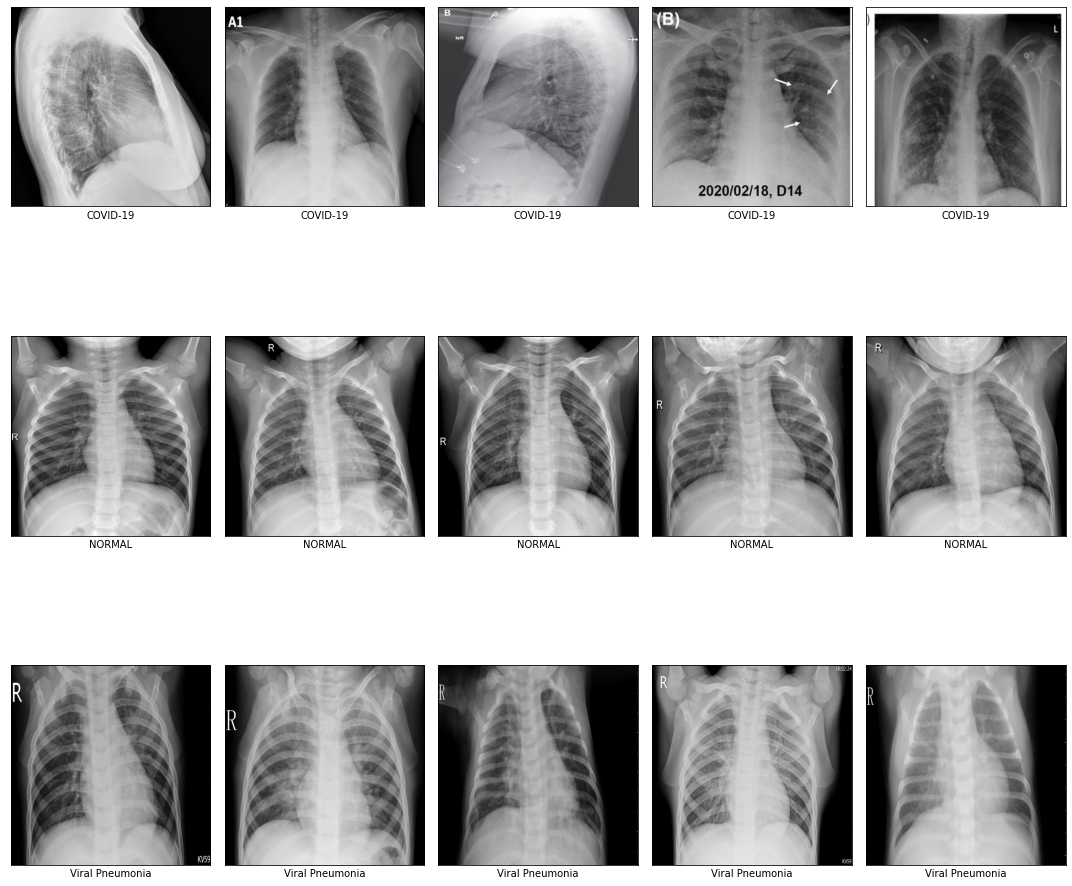

In [4]:
fig, axs = plt.subplots(len(labels), 5, figsize = (15, 15))

class_len = {}
for i, c in enumerate(labels):
    class_path = os.path.join(path, c)
    all_images = os.listdir(class_path)
    sample_images = random.sample(all_images, 5)
    class_len[c] = len(all_images)
    
    for j, image in enumerate(sample_images):
        img_path = os.path.join(class_path, image)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel = c, xticks = [], yticks = [])

fig.tight_layout()

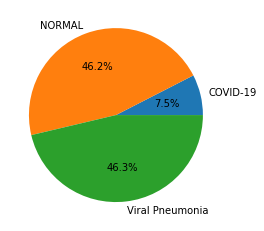

In [5]:
fig, ax = plt.subplots()
ax.pie(
    class_len.values(),
    labels = class_len.keys(),
    autopct = "%1.1f%%"
)
fig.show()

In [6]:
datagen_train = ImageDataGenerator(
    rescale = 1./255, 
    validation_split = 0.2,
    rotation_range = 5,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    zoom_range = 0.01
)

datagen_val = ImageDataGenerator(
    rescale = 1./255, 
    validation_split = 0.2 
)    

train_generator = datagen_train.flow_from_directory(
    directory = path,
    classes = labels,
    seed = 42,
    batch_size = 32, 
    shuffle = True,
    subset = 'training'
)

val_generator = datagen_val.flow_from_directory(
    directory = path,
    classes = labels,
    seed = 42,
    batch_size = 32, 
    shuffle = True,
    subset = 'validation'
)

Found 2325 images belonging to 3 classes.
Found 580 images belonging to 3 classes.


In [7]:
set(val_generator.filenames).intersection(set(train_generator.filenames))
val_generator.class_indices

{'COVID-19': 0, 'NORMAL': 1, 'Viral Pneumonia': 2}

In [8]:
basemodel = InceptionV3(
    include_top = False, 
    weights = 'imagenet', 
    input_tensor = Input((256, 256, 3)),
)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [9]:
basemodel.trainable = False
basemodel.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [10]:
headmodel = basemodel.output
headmodel = GlobalAveragePooling2D()(headmodel)
headmodel = Flatten()(headmodel) 
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(3, activation = "softmax")(headmodel) # 3 classes

model = Model(inputs = basemodel.input, outputs = headmodel)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [13]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [14]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = 64,
    epochs = 10
)

Epoch 1/10
64/64 [==============================] - 258s 4s/step - loss: 0.7098 - acc: 0.6770
Epoch 2/10
64/64 [==============================] - 253s 4s/step - loss: 0.5085 - acc: 0.7958
Epoch 3/10
64/64 [==============================] - 249s 4s/step - loss: 0.4467 - acc: 0.8267
Epoch 4/10
64/64 [==============================] - 248s 4s/step - loss: 0.3519 - acc: 0.8670
Epoch 5/10
64/64 [==============================] - 250s 4s/step - loss: 0.3715 - acc: 0.8621
Epoch 6/10
64/64 [==============================] - 248s 4s/step - loss: 0.3629 - acc: 0.8655
Epoch 7/10
64/64 [==============================] - 247s 4s/step - loss: 0.3391 - acc: 0.8738
Epoch 8/10
64/64 [==============================] - 253s 4s/step - loss: 0.3190 - acc: 0.8804
Epoch 9/10
64/64 [==============================] - 775s 12s/step - loss: 0.3527 - acc: 0.8645
Epoch 10/10
64/64 [==============================] - 745s 12s/step - loss: 0.3188 - acc: 0.8832


In [15]:
score = model.evaluate_generator(train_generator)

In [32]:
print('Exactitud: {}'.format(score[1]) )

Exactitud: 0.7212903499603271


In [17]:
save_path = "./keras_model/"
model.save_weights(os.path.join(save_path,"model-weights.h5"))
model_json = model.to_json()
with open(os.path.join(save_path,"model.json"), "w") as json_file:
    json_file.write(model_json)

In [21]:
role = get_execution_role()
sagemaker_session = sagemaker.Session()

In [41]:
val_generator = datagen_val.flow_from_directory(
    directory = path,
    classes = labels,
    seed = 42,
    batch_size = 32, 
    shuffle = False,
    subset = 'validation'
)

Found 580 images belonging to 3 classes.


In [45]:
pred = model.predict_generator(val_generator) # Gives class probabilities
pred = np.round(pred) # Gives one-hot encoded classes
pred = np.argmax(pred, axis = 1) # Gives class labels

actual = val_generator.classes
print(pred)

[2 2 2 2 2 2 2 2 1 1 1 2 2 1 1 2 2 1 2 2 2 2 2 1 2 2 2 2 2 1 2 1 1 2 1 2 2
 2 2 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1
 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 2
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1
 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 2 2 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2
 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 2 1 1 2 1 2 2 2 2 2 1 1 2 2 1 1 2 2 2 1 1
 2 1 1 1 1 1 2 1 1 1 2 2 1 1 1 2 1 1 1 1 2 2 2 1 1 1 1 1 1 1 1 2 1 2 1 1 1
 2 2 2 1 1 1 2 2 2 1 2 1 2 2 1 2 1 1 1 1 2 1 1 1 2 2 1 2 2 2 1 1 1 2 1 2 2
 2 1 2 2 1 2 1 1 1 1 2 2 1 1 2 2 2 2 1 1 2 2 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1
 1 2 2 1 2 1 2 1 2 1 1 1 1 2 1 1 1 2 2 1 1 2 1 1 2 2 1 1 1 1 2 1 2 1 2 2 2
 2 1 1 2 2 1 1 1 1 1 2 2 

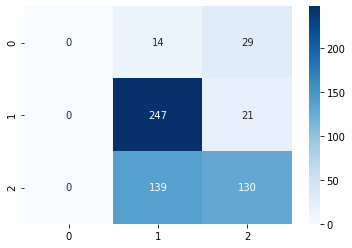

In [43]:
cm = confusion_matrix(actual, pred, labels = [0, 1, 2])
sns.heatmap(
    cm, 
    cmap="Blues",
    annot = True, 
    fmt = "d"
)
plt.show()


In [44]:
print(classification_report(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        43
           1       0.62      0.92      0.74       268
           2       0.72      0.48      0.58       269

    accuracy                           0.65       580
   macro avg       0.45      0.47      0.44       580
weighted avg       0.62      0.65      0.61       580



/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
tf.saved_model.save(model, 'keras_model/modelo')

INFO:tensorflow:Assets written to: keras_model/modelo/assets
